# Sales Forecast


We ask you to begin creating a prototype model from the dataset below, which consists of an international online retailer’s transactions from 2010-2011

- To demonstrate your ability to do predictive modeling, demonstrate to us how you would go about forecasting daily sales
    - Given this retailer’s 2010-2011 transactions in the datatest, predict the amount (€) this retailer will sell each day of 2012


#### Library Imports

In [120]:
import os
import logging
import pandas as pd
import itertools
import time
import sys
# import warnings

import statsmodels.api as sm

import matplotlib.pyplot as plt

from statsmodels.tsa.vector_ar.var_model import VAR

# warnings.filterwarnings("ignore")


### Configuration variables

In [80]:
config_dict={
    "log_directory": "/Users/guillem/tmp/",
    "log_level": "DEBUG",
    "base_name": "sales_forecast",
    "input_file_path": "/Users/guillem/Downloads/Online Retail.xlsx",
    "split_date": "2011-11-01"
}

### Procedures

In [81]:
#### INIT LOGGER ################################################################################
def init_logger(log_level, file_location, log_filename):
    """Initializes log structure. """
    logger = logging.getLogger()
    logger.setLevel(log_level)
    timestr = time.strftime("%Y%m%d%H%M%S")
    log_full_path = os.path.normpath(file_location + '/' + timestr + '_'+ log_filename)

    time_format = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    logging.basicConfig(level=log_level,
                        format=time_format,
                        filename=log_full_path,
                        filemode='w')

    ch = logging.StreamHandler(sys.stdout)
    # ch.setLevel('INFO')
    formatter = logging.Formatter(time_format)
    ch.setFormatter(formatter)
    logger.addHandler(ch)

    return logger


#### READ DATA FILE #############################################################
def read_data_file(config_dict, log):
    """Reads process data excel file and returns the corresponding dataframe"""
    file_path = config_dict["input_file_path"]
    log.info('Reading excel file: %s' % file_path)
    file_df = pd.read_excel(file_path, header=0)
    log.debug("data shape: {}".format(file_df.shape))

    # Remove duplicated records
    # Assuming duplicates should not exist
    log.info('Removing duplicates...')
    file_df.drop_duplicates(keep='last', inplace=True)
    log.debug("all data shape: {}".format(file_df.shape))

    # Drop unnamed columns
    log.info('Dropping unnamed columns...')
    drop = []
    for c in file_df.columns:
        if 'unnamed' in c.lower():
            drop.append(c)
    if len(drop) > 0:
        file_df.drop(columns=drop, inplace=True)
        log.debug("all data shape: {}".format(file_df.shape))

    # TODO set types

    return file_df


#### PROCESS DATA #############################################################
def process_data(df, log):
    """Processes raw data into ML ready time series data
       Returns a dataframe indexed by date including daily sales"""
    
    log.info('Cleaning data...')
    
    # 0 unit prices seem to represent thrown units, not sales
    # REMOVE 0 unit prices information
    log.info('Removing non sales data...')
    df = df[(df["UnitPrice"] != 0)].copy()
    log.debug("data shape: {}".format(df.shape))
    
    # a couple rows exist with negative unit prices and description "Adjust bad debt" (to be checked with business)
    # those will be kept as they probably represent valid transactions
    
    # cancellation transactions observed seem to have the same date as their corresponding sale
    # therefore their sum should be neutral in the daily sales aggregation and there's no need to clean manually
    
    log.info('Adding group columns...')
    df['Date'] = pd.to_datetime(df['InvoiceDate']).dt.date
    df['InvoiceAmount'] = (df["UnitPrice"] * df["Quantity"]).round(2)
    log.debug("data shape: {}".format(df.shape))
    
    log.info('Grouping data by daily sales...')
    daily_sales = df.groupby(["Date"]).sum()[["InvoiceAmount"]]
    daily_sales.rename(columns={"InvoiceAmount": "TotalSales"}, inplace=True)
    daily_sales.index = pd.to_datetime(daily_sales.index)
    daily_sales["weekday"] = daily_sales.index.weekday
    daily_sales["monthday"] = daily_sales.index.day
    # month and year are not useful as we only have 1 year data
    # other features such as a holiday could be added
    # data could also be separated by country and by product
    # This way we would train a model for each country/product to obtain more accurate prediction results
    
    full_date_range = pd.date_range(start="2010-12-01", end="2011-12-09", freq="D")
    daily_sales = daily_sales.reindex(full_date_range, fill_value=0)
    # added daily sales maybe could also be interpolated (to be tested)
    
    log.debug("daily sales shape: {}".format(daily_sales.shape))
    
    return daily_sales
    
    
    # add date field
    
    # clean ideas: 0 priced units
    # check empty descriptions
    # check "throw away"
    # "Adjust bad depbt"
    
    
    # cancellations clean
    
    # group by customer and date and sum sales
    
    # keep only date and sales columns
    # day of month, day of the week, holiday (from country), sales number

### Init Log

In [42]:
# initialize logger
log = init_logger(config_dict["log_level"], config_dict["log_directory"], config_dict["base_name"] + '.log')

### Read data file

In [43]:
df = read_data_file(config_dict, log)
df.shape

2022-11-13 18:20:07,061 - root - INFO - Reading excel file: /Users/guillem/Downloads/Online Retail.xlsx
2022-11-13 18:20:07,061 - root - INFO - Reading excel file: /Users/guillem/Downloads/Online Retail.xlsx
2022-11-13 18:21:06,088 - root - DEBUG - data shape: (541909, 8)
2022-11-13 18:21:06,088 - root - DEBUG - data shape: (541909, 8)
2022-11-13 18:21:06,092 - root - INFO - Removing duplicates...
2022-11-13 18:21:06,092 - root - INFO - Removing duplicates...
2022-11-13 18:21:06,451 - root - DEBUG - all data shape: (536641, 8)
2022-11-13 18:21:06,451 - root - DEBUG - all data shape: (536641, 8)
2022-11-13 18:21:06,453 - root - INFO - Dropping unnamed columns...
2022-11-13 18:21:06,453 - root - INFO - Dropping unnamed columns...


(536641, 8)

In [44]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [45]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [57]:
daily_sales = process_data(df, log)
daily_sales.head()

2022-11-13 18:32:28,271 - root - INFO - Cleaning data...
2022-11-13 18:32:28,271 - root - INFO - Cleaning data...
2022-11-13 18:32:28,278 - root - INFO - Removing non sales data...
2022-11-13 18:32:28,278 - root - INFO - Removing non sales data...
2022-11-13 18:32:28,371 - root - DEBUG - data shape: (534131, 8)
2022-11-13 18:32:28,371 - root - DEBUG - data shape: (534131, 8)
2022-11-13 18:32:28,373 - root - INFO - Adding group columns...
2022-11-13 18:32:28,373 - root - INFO - Adding group columns...
2022-11-13 18:32:28,556 - root - DEBUG - data shape: (534131, 10)
2022-11-13 18:32:28,556 - root - DEBUG - data shape: (534131, 10)
2022-11-13 18:32:28,557 - root - INFO - Grouping data by daily sales...
2022-11-13 18:32:28,557 - root - INFO - Grouping data by daily sales...
2022-11-13 18:32:28,648 - root - DEBUG - daily sales shape: (305, 3)
2022-11-13 18:32:28,648 - root - DEBUG - daily sales shape: (305, 3)


,TotalSales,weekday,monthday
Date,,,
2010-12-01,58451.56,2,1
2010-12-02,46088.32,3,2
2010-12-03,45575.38,4,3
2010-12-05,30973.63,6,5
2010-12-06,53653.87,0,6


### Data display

<AxesSubplot:>

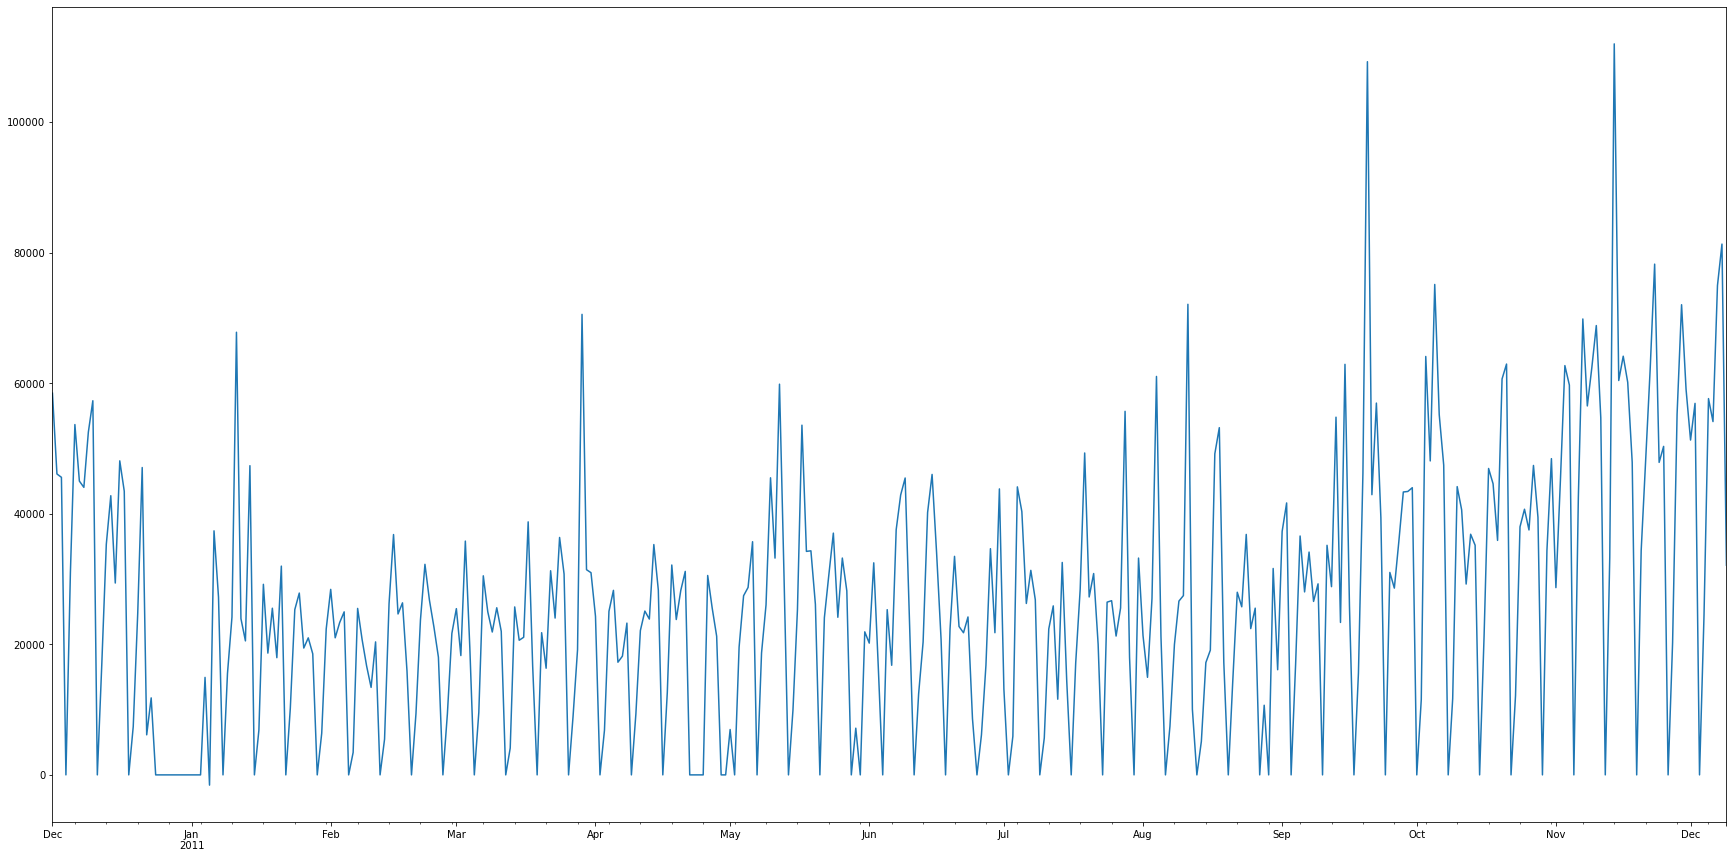

In [88]:
plt.rcParams["figure.figsize"] = (30,15)
daily_sales["TotalSales"].plot()

### Prepare ML datasets

In [89]:
X = daily_sales[["weekday", "monthday"]]
Y = daily_sales[["TotalSales"]].asfreq('D')

### Time Series decomposition

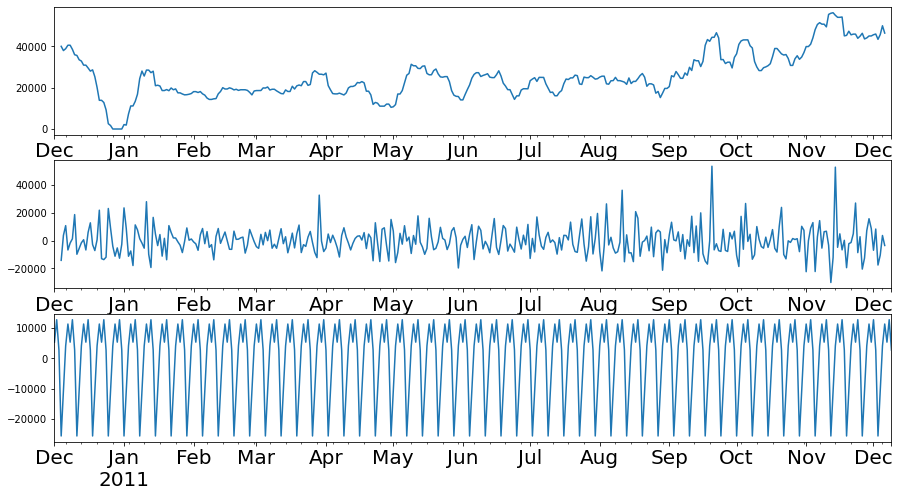

In [121]:
decomposition = sm.tsa.seasonal_decompose(Y, model='additive')
#fig = decomposition.plot()
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
decomposition.trend.plot(ax=ax1)
decomposition.resid.plot(ax=ax2)
decomposition.seasonal.plot(ax=ax3)
plt.rcParams["figure.figsize"] = (30,30)
plt.rcParams["xtick.labelsize"] = 20
plt.show()

From the above graph sales appear to be instable and have a strong seasonability.

We are going to test modeling weith ARIMA by using all possible parameters combinations

### Prepare ARIMA parameter combinations

Seasonality, trend and noise combinations should be tested.

In [116]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [117]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [126]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(Y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=0)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:8815.145215585146
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:8441.41885340282
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:8413.533828505064
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:7939.333184936787
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:8370.927087544664
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:8196.275542270694
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:8060.94377609813
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:7913.100983329152
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:8599.616774602773
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:8298.87921738315
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:8341.742687652502
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:7900.757636102882
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:8330.096611275552
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:8230.967145639068
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:8008.716807502666
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:7896.377774634633
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:8477.404403493383
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:8179.543007112942
ARIMA(0, 1, 0

The best resulting execution is the following:
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:7895.831199603271

### Fit model (with all data) and view results

In [127]:
mod = sm.tsa.statespace.SARIMAX(Y,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12))
results = mod.fit(disp=0)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1080      0.233      0.464      0.643      -0.348       0.564
ma.L1          0.2906      0.219      1.325      0.185      -0.139       0.720
ar.S.L12      -0.1990      0.135     -1.469      0.142      -0.464       0.066
ma.S.L12      -0.7885      0.091     -8.684      0.000      -0.966      -0.611
sigma2      6.697e+08   5.33e-11   1.26e+19      0.000     6.7e+08     6.7e+08


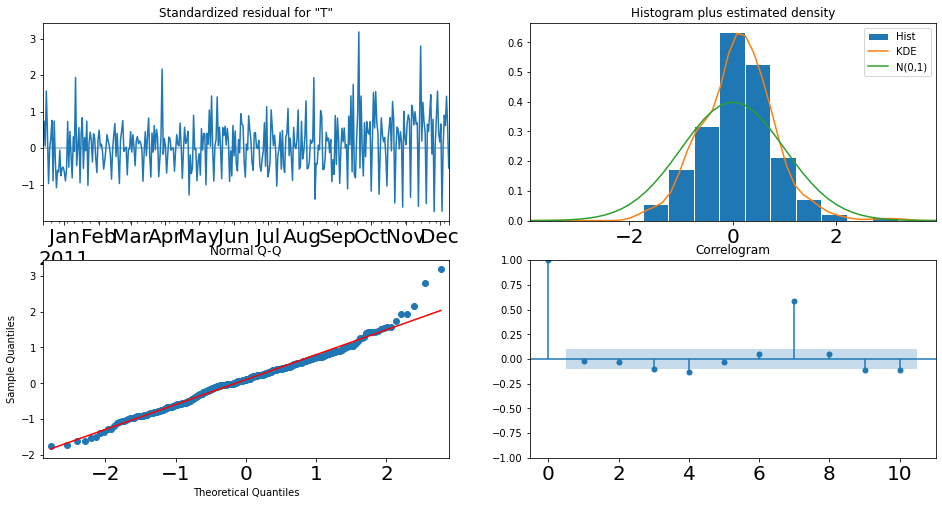

In [128]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

**Standard residual** show no pattern or correlation which is good.

**Histogram** distribution is far from perfect (green line) but almost looks Gaussian

**Quantiles correlation** looks quite constant except for high values

### Print forecast results:

In [134]:
pred = results.get_prediction(start=pd.to_datetime('2011-08-01'), dynamic=False)
pred_conf_interval = pred.conf_int()

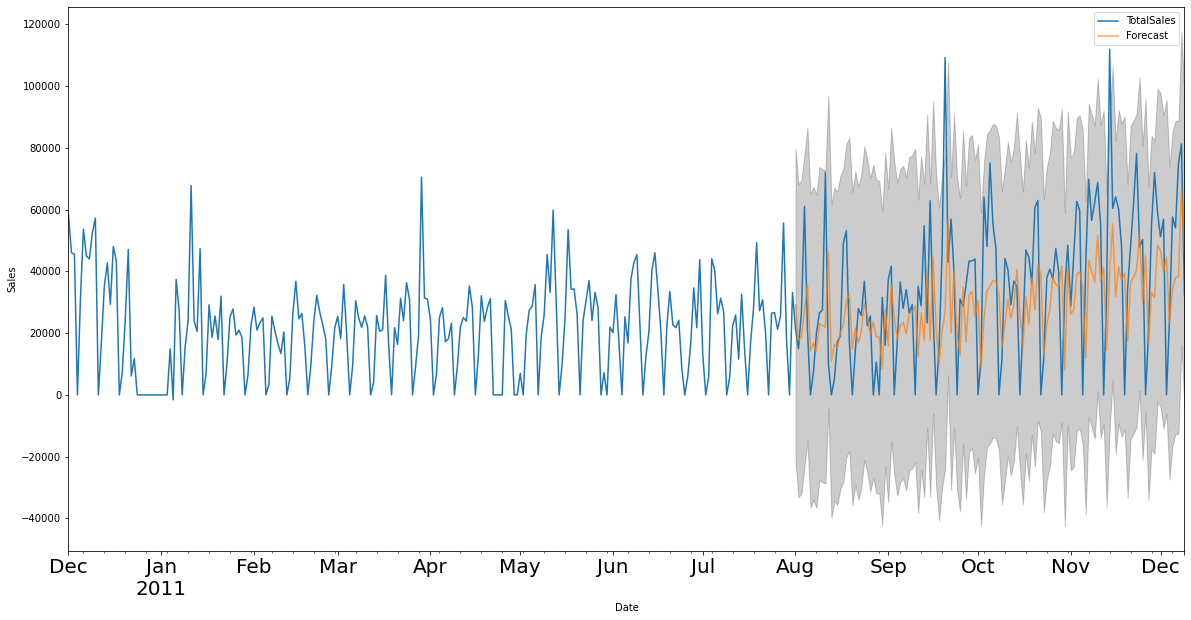

In [142]:
ax = Y['2010-12-01':].plot()
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(20, 10))
ax.fill_between(pred_conf_interval.index,
                pred_conf_interval.iloc[:, 0],
                pred_conf_interval.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()